In [1]:
import librosa
import numpy as np
import pandas as pd

import os
import csv

In [ ]:
genres = os.listdir("./sound-creator/albums//")

for genre in genres:
    if(os.path.isfile(os.path.join("./sound-creator/albums/", genre))): continue
    
    counter = 0
    print(f'--------- {genre.upper()} -------------')
    artists = os.listdir(os.path.join("./sound-creator/albums/", genre))
    for artist in artists:
        if not (os.path.exists(os.path.join("./sound-creator/albums/", genre, artist))): continue
        if(os.path.isfile(os.path.join("./sound-creator/albums/", genre, artist))): continue
        albums = os.listdir(os.path.join("./sound-creator/albums/", genre, artist))
        for album in albums:
            if not (os.path.exists(os.path.join("./sound-creator/albums/", genre, artist, album))): continue
            if(os.path.isfile(os.path.join("./sound-creator/albums/", genre, artist, album))): continue
            counter+=1
            if(os.path.isfile(os.path.join("./sound-creator/output/", genre, f'{artist} - {album}_mfccs.npy'))): 
                print(os.path.join("./sound-creator/output/", genre, f'{artist} - {album}_mfccs.npy')+' exists')
                continue
            print(f'Processing ({counter}) {artist} - {album}')
            album_mfccs = np.zeros((0, 10, 39))
            files = os.listdir(os.path.join("./sound-creator/albums/", genre, artist, album))
            if len(files) == 0: 
                print('Sem arquivos')
                continue
            album_audio = []
            album_sr = 0
            for file in files:
                filepath = os.path.join("./sound-creator/albums/", genre, artist, album, file)
                y, sr = librosa.load(filepath)
                album_audio += y.tolist()
                album_sr = sr
                
            album_audio = np.array([album_audio[i-album_sr*5:i] for i in range(album_sr*5, len(album_audio), album_sr*5)][0:-1])
            
            for audio in album_audio:
                n_fft = 2048
                hop_length = int(audio.shape[0]/9)

                mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=album_sr, n_fft=n_fft, hop_length=hop_length, n_mels=128, fmax=8000)
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
                # librosa.display.specshow(log_mel_spectrogram, x_axis="time", y_axis="mel", sr=sr)

                mfccs = librosa.feature.mfcc(S=mel_spectrogram, n_mfcc=13)
                delta1 = librosa.feature.delta(mfccs)
                delta2 = librosa.feature.delta(mfccs, order=2)

                mfccs = np.swapaxes(np.concatenate((mfccs, delta1, delta2)), 0, 1)
                album_mfccs = np.concatenate([album_mfccs, mfccs.reshape(1, 10, 39)])

            np.save(open(os.path.join("./sound-creator/output/", genre, f'{artist} - {album}_mfccs.npy'), 'wb'), album_mfccs)
            # os.remove(os.path.join("./sound-creator/output/", genre, f'{artist} - {album}_mfccs.npy'))

In [2]:
# IMPORTA COMO MATRIZ (X, 10, 39) -> JANELAS DE 5 SEGUNDOS

import numpy as np
import math
from  sklearn.preprocessing import StandardScaler

genres = os.listdir("./sound-creator/output")
albums_info = []
df = np.zeros((0, 10, 39))
classes = np.zeros((0, 5))
for g, genre in enumerate(genres):
    if(os.path.isfile(os.path.join("./sound-creator/output/", genre))): continue
    mfcc_files = os.listdir(os.path.join("./sound-creator/output/", genre))
    for mfcc_file in mfcc_files:
        if(os.path.isdir(os.path.join("./sound-creatoroutput/", genre, mfcc_file))): continue
        
        mfccs = np.load(open(os.path.join("./sound-creator/output/", genre, mfcc_file), 'rb'))
        albums_info.append([
            mfcc_file.split('_mfccs')[0],
            (df.shape[0], df.shape[0] + mfccs.shape[0]),
            mfccs.shape[0]
        ] + [g == i for i in range(len(genres))])
        classes = np.concatenate([classes, np.array([g == i for i in range(len(genres))] * mfccs.shape[0]).reshape(mfccs.shape[0], 5)])

        df = np.concatenate([df, mfccs], axis=0)

# df = df.reshape(df.shape[0], 130)
df = (df - df.min()) / (df.max() - df.min())
print(df.shape)
albums_info = pd.DataFrame(albums_info, columns=['Album', 'Position', 'Length', 'Folk', 'HipHop', 'Jazz', 'R&B', 'Rock'])
folk_samples = int(len(albums_info[albums_info['Folk']])/4)
hiphop_samples = int(len(albums_info[albums_info['HipHop']])/4)
jazz_samples = int(len(albums_info[albums_info['Jazz']])/4)
rnb_samples = int(len(albums_info[albums_info['R&B']])/4)
rock_samples = int(len(albums_info[albums_info['Rock']])/4)

random_state = 1
test_albums = pd.concat(
    [albums_info[albums_info['Folk']].sample(folk_samples, random_state=random_state), # 'Folk'
     albums_info[albums_info['HipHop']].sample(hiphop_samples, random_state=random_state), # 'HipHop'
     albums_info[albums_info['Jazz']].sample(jazz_samples, random_state=random_state), # 'Jazz'
     albums_info[albums_info['R&B']].sample(rnb_samples, random_state=random_state), # 'R&B'
     albums_info[albums_info['Rock']].sample(rock_samples, random_state=random_state),] # 'Rock'
)
validation_albums = pd.concat(
    [albums_info[albums_info['Folk'] & (~albums_info['Album'].isin(test_albums['Album']))].sample(folk_samples, random_state=random_state), # 'Folk'
     albums_info[albums_info['HipHop'] & (~albums_info['Album'].isin(test_albums['Album']))].sample(hiphop_samples, random_state=random_state), # 'HipHop'
     albums_info[albums_info['Jazz'] & (~albums_info['Album'].isin(test_albums['Album']))].sample(jazz_samples, random_state=random_state), # 'Jazz'
     albums_info[albums_info['R&B'] & (~albums_info['Album'].isin(test_albums['Album']))].sample(rnb_samples, random_state=random_state), # 'R&B'
     albums_info[albums_info['Rock'] & (~albums_info['Album'].isin(test_albums['Album']))].sample(rock_samples, random_state=random_state),] # 'Rock'
)
train_albums = albums_info[~(albums_info['Album'].isin(test_albums['Album']) | albums_info['Album'].isin(validation_albums['Album']))]

X = np.concatenate([df[pos[0]:pos[1]] for pos in list(train_albums['Position'])])
X1 = np.concatenate([df[pos[0]:pos[1]] for pos in list(test_albums['Position'])])
X2 = np.concatenate([df[pos[0]:pos[1]] for pos in list(validation_albums['Position'])])
y = (np.concatenate([classes[pos[0]:pos[1]] for pos in list(train_albums['Position'])]))
y1 = (np.concatenate([classes[pos[0]:pos[1]] for pos in list(test_albums['Position'])]))
y2 = (np.concatenate([classes[pos[0]:pos[1]] for pos in list(validation_albums['Position'])]))
y1_albums = test_albums.iloc[:, -5:].to_numpy()

p_aux = list(test_albums['Length'].cumsum())
p_aux = [(0, p_aux[0])] + [(p_aux[i]+1, l) for i, l in enumerate(p_aux[1:])]

del df

(246216, 10, 39)


In [25]:
total_albums = pd.DataFrame([train_albums[['Folk', 'HipHop', 'Jazz', 'R&B', 'Rock']].sum(), test_albums[['Folk', 'HipHop', 'Jazz', 'R&B', 'Rock']].sum(), validation_albums[['Folk', 'HipHop', 'Jazz', 'R&B', 'Rock']].sum()], index=['Treino', 'Teste', 'Validação'])

total_albums['Total'] = total_albums.sum(axis=1)
print('Álbuns')
total_albums
# albums_info[albums_info['Folk'] & (~albums_info['Album'].isin(test_albums['Album']))].sample(folk_samples, random_state=random_state)

Álbuns


,Folk,HipHop,Jazz,R&B,Rock,Total
Treino,31,37,39,39,39,185
Teste,15,18,19,18,19,89
Validação,15,18,19,18,19,89


In [3]:
from keras import Sequential, backend, models
from keras.layers import LSTM, Dense, Conv2D, Input, Flatten
from keras.callbacks import ModelCheckpoint
import json, os

model = Sequential()
model.add(Input(shape=(10, 39, 1)))
model.add(Conv2D(filters=32, kernel_size=3))
model.add(Conv2D(filters=64, kernel_size=3))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

backend.set_value(model.optimizer.learning_rate, 0.0005)

model.save('./model/output/keras/Conv2D_lr-00005/simpleConv2D.keras')
# model.load_weights('./model/output/keras/Conv2D_lr-00000125/model_CONV2D_50.h5')

checkpoint_path = "./model/output/keras/Conv2D_lr-00005/model_CONV2D_{epoch}.h5"

cp_callback = ModelCheckpoint(
   checkpoint_path, verbose=0, save_weights_only=True, monitor='val_accuracy', mode='max')

model.save_weights(checkpoint_path.format(epoch=0))
model.fit(X, y, batch_size=16, callbacks = [cp_callback], epochs=10, validation_data=(X2, y2))

json.dump(dict(model.history.history), open(os.path.join(os.path.dirname(checkpoint_path), 'history2'), 'w'))

Epoch 1/10
8083/8083 [==============================] - 57s 7ms/step - loss: 1.3898 - accuracy: 0.3887 - val_loss: 1.3888 - val_accuracy: 0.4230
Epoch 2/10
8083/8083 [==============================] - 54s 7ms/step - loss: 1.3006 - accuracy: 0.4461 - val_loss: 1.3606 - val_accuracy: 0.4551
Epoch 3/10
8083/8083 [==============================] - 55s 7ms/step - loss: 1.2595 - accuracy: 0.4658 - val_loss: 1.3479 - val_accuracy: 0.4657
Epoch 4/10
8083/8083 [==============================] - 55s 7ms/step - loss: 1.2327 - accuracy: 0.4802 - val_loss: 1.3529 - val_accuracy: 0.4556
Epoch 5/10
8083/8083 [==============================] - 54s 7ms/step - loss: 1.2109 - accuracy: 0.4903 - val_loss: 1.3497 - val_accuracy: 0.4656
Epoch 6/10
8083/8083 [==============================] - 54s 7ms/step - loss: 1.1927 - accuracy: 0.5006 - val_loss: 1.3455 - val_accuracy: 0.4570
Epoch 7/10
8083/8083 [==============================] - 54s 7ms/step - loss: 1.1743 - accuracy: 0.5083 - val_loss: 1.4009 - val_ac

In [24]:
from keras import Sequential, backend
from keras.layers import LSTM, Dense, Input, Flatten
from keras.callbacks import ModelCheckpoint
import json, os

model = Sequential()
model.add(Input(shape=(10, 39)))
model.add(LSTM(64, return_sequences=True, dropout=0.2))
model.add(LSTM(64, return_sequences=True, dropout=0.2))
model.add(LSTM(64, return_sequences=False, dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

backend.set_value(model.optimizer.learning_rate, 0.00025)

model.save('./model/output/keras/LSTM_lr-000025/simpleLSTM.keras')


checkpoint_path = "./model/output/keras/LSTM_lr-000025/model_LSTM_{epoch}.h5"

cp_callback = ModelCheckpoint(
   checkpoint_path, verbose=0, save_weights_only=True, monitor='val_accuracy', mode='max')

model.save_weights(checkpoint_path.format(epoch=0))
model.fit(X, y, batch_size=16, callbacks = [cp_callback], epochs=10, validation_data=(X2, y2))

json.dump(dict(model.history.history), open(os.path.join(os.path.dirname(checkpoint_path), 'history'), 'w'))

Epoch 1/10
8083/8083 [==============================] - 77s 9ms/step - loss: 1.5795 - accuracy: 0.2490 - val_loss: 1.5724 - val_accuracy: 0.2136
Epoch 2/10
8083/8083 [==============================] - 70s 9ms/step - loss: 1.5592 - accuracy: 0.2649 - val_loss: 1.5702 - val_accuracy: 0.2136
Epoch 3/10
8083/8083 [==============================] - 70s 9ms/step - loss: 1.5425 - accuracy: 0.2740 - val_loss: 1.5702 - val_accuracy: 0.2317
Epoch 4/10
8083/8083 [==============================] - 70s 9ms/step - loss: 1.5322 - accuracy: 0.2822 - val_loss: 1.5701 - val_accuracy: 0.2691
Epoch 5/10
8083/8083 [==============================] - 70s 9ms/step - loss: 1.5259 - accuracy: 0.2869 - val_loss: 1.5878 - val_accuracy: 0.2425
Epoch 6/10
8083/8083 [==============================] - 69s 9ms/step - loss: 1.5193 - accuracy: 0.2931 - val_loss: 1.5586 - val_accuracy: 0.2800
Epoch 7/10
8083/8083 [==============================] - 70s 9ms/step - loss: 1.5117 - accuracy: 0.2968 - val_loss: 1.5740 - val_ac

In [47]:
from keras import models, backend
from keras.callbacks import ModelCheckpoint

accs = []
model = models.load_model('./model/output/keras/Conv2D_lr-000025/simpleConv2D.keras')
for f in os.listdir('./model/output/keras/Conv2D_lr-000025/'):
    if(not f.endswith('.h5')): continue
    model.load_weights(os.path.join('./model/output/keras/Conv2D_lr-000025/', f))
    accs.append(model.evaluate(X2, y2)[1])
accs.index(max(accs)), max(accs)

1821/1821 [==============================] - 5s 3ms/step - loss: 1.3449 - accuracy: 0.4762


(36, 0.4762280583381653)

In [21]:
import json

history = json.load(open('./model/output/keras/Conv2D_lr-0000025/history')) 
history2 = json.load(open('./model/output/keras/Conv2D_lr-0000025/history2'))

val_accuracy = history['val_accuracy'] + history2['val_accuracy']
val_accuracy.index(max(val_accuracy)), max(val_accuracy)

(30, 0.4779444634914398)

In [27]:
from sklearn import metrics
from scipy import stats
from sklearn.dummy import DummyClassifier
import datetime
import pickle
def fit_and_generate(clf, X, y, X1, y1, y_aux, custom_name=None, train=True):
    init_time = datetime.datetime.now()
    if(train): 
        clf.fit(X, y)
        if(custom_name): open(f'./model/output/sklearn/{custom_name}', 'wb').write(pickle.dumps(clf)) 
        else: open(f'./model/output/sklearn/{clf}', 'wb').write(pickle.dumps(clf)) 
    p1_raw = clf.predict(X1)

    p1 = np.zeros((0, 5))
    for l in p_aux:
        p1 = np.concatenate([p1, p1_raw[l[0]:l[1], :].sum(axis=0).reshape((1,5))], axis=0)
    res = f'''{clf} - accuracy={round(metrics.accuracy_score(y1_albums.argmax(axis=1), p1.argmax(axis=1))*100, 4)}% -  f1={round(metrics.f1_score(y1_albums.argmax(axis=1), p1.argmax(axis=1), average="weighted")*100, 4)}% - recall={round(metrics.recall_score(y1_albums.argmax(axis=1), p1.argmax(axis=1), average="weighted")*100, 4)}%'''

    # p1 = np.array([stats.mode(p1_raw[l[0]:l[1]])[0][0] for l in p_aux]).reshape(20, 1)
    print(res)
    return p1_raw
    
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, set_config

p1_dummy = fit_and_generate(DummyClassifier(strategy='uniform'), X.reshape(X.shape[0], 390), y, X1.reshape(X1.shape[0], 390), y1, p_aux, custom_name='DummyClassifier')
p1_neigh = fit_and_generate(KNeighborsClassifier(), X.reshape(X.shape[0], 390), y, X1.reshape(X1.shape[0], 390), y1, p_aux)
p1_tree = fit_and_generate(DecisionTreeClassifier(),  X.reshape(X.shape[0], 390), y, X1.reshape(X1.shape[0], 390), y1, p_aux)
p1_forest = fit_and_generate(RandomForestClassifier(n_estimators=5), X.reshape(X.shape[0], 390), y, X1.reshape(X1.shape[0], 390), y1, p_aux, custom_name='RandomForestClassifier')
p1_xgb = fit_and_generate(XGBClassifier(device="cuda", tree_method="hist"), X.reshape(X.shape[0], 390), y, X1.reshape(X1.shape[0], 390), y1, p_aux, custom_name='XGBClassifier')

DummyClassifier(strategy='uniform') - accuracy=23.5955% -  f1=24.1187% - recall=23.5955%
KNeighborsClassifier() - accuracy=56.1798% -  f1=49.6545% - recall=56.1798%
DecisionTreeClassifier() - accuracy=68.5393% -  f1=65.3757% - recall=68.5393%
RandomForestClassifier(n_estimators=5) - accuracy=66.2921% -  f1=58.5051% - recall=66.2921%
[10:51:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=No

In [16]:
X.shape

(1278270, 10, 13)

In [ ]:
p1 = np.zeros((0, 5))
print(p1.shape)
for l in p_aux:
    print(p1_xgb[l[0]:l[1], :].sum(axis=0).reshape((1,5)))
    p1 = np.concatenate([p1, p1_xgb[l[0]:l[1], :].sum(axis=0).reshape((1,5))], axis=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import optuna
import pickle

# Define objective function
def objective(trial):
    if trial.number % 10==0: print('█', end='')
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 5, 100, log=True)
    # max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestClassifier(
    n_estimators=n_estimators,
    # max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    )
    model.fit(X, y)

    # Make predictions and calculate RMSE
    y_pred = model.predict(X1)
    # rmse = np.sqrt(mean_squared_error(y1_true, y_pred))
    # mae = mean_absolute_error(y1_true, y_pred)
    # r2 = r2_score(y1_true, y_pred)
    acc = accuracy_score(y1, y_pred)

    return acc



# Create study object
study = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.DEBUG)
# Run optimization process
study.optimize(objective, n_trials=10)

model = RandomForestClassifier(
n_estimators=study.best_trial.params['n_estimators'],
# max_depth=study.best_trial.params['max_depth'],
min_samples_split=study.best_trial.params['min_samples_split'],
min_samples_leaf=study.best_trial.params['min_samples_leaf'],
)
model.fit(X, y)

# Make predictions and calculate RMSE
y_pred = model.predict(X1)
# rmse = np.sqrt(mean_squared_error(y1_true, y_pred))
# mae = mean_absolute_error(y1_true, y_pred)
# r2 = r2_score(y1_true, y_pred)
acc = accuracy_score(y1, y_pred)
print(study.best_trial.params)
print(acc)
print(study.trials_dataframe(attrs=['duration']).median())

open(f'./model/output/RandomForestClassifier', 'wb').write(pickle.dumps(model)) 

# {'n_estimators': 10, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 1}
# accuracy: 0.24883333333333332
# median duration: 00:00:04.361455500

In [31]:
from xgboost import XGBClassifier, set_config
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import optuna

set_config(verbosity=0)

# Define objective function
def objective(trial):
    if trial.number % 10==0: print('█', end='')
    # Suggest values for hyperparameters
    max_depth = trial.suggest_int("max_depth", 4, 100, log=True)
    eta = trial.suggest_float("eta", 0.01, 0.2, step=0.0001)
    gamma = trial.suggest_int("gamma", 1000, 1000000, log=True)

    # Create and fit random forest model
    model = XGBClassifier(device="cuda", tree_method="hist", max_depth=max_depth, gamma=gamma, eta=eta)
    model.fit(X, y)

    # Make predictions and calculate RMSE
    y_pred = model.predict(X1)
    # rmse = np.sqrt(mean_squared_error(y1_true, y_pred))
    # mae = mean_absolute_error(y1_true, y_pred)
    # r2 = r2_score(y1_true, y_pred)
    acc = accuracy_score(y1, y_pred)
    return acc



# Create study object
study = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run optimization process
study.optimize(objective, n_trials=1000)

model = XGBClassifier(device="cuda", tree_method="hist", max_depth=study.best_trial.params['max_depth'], 
                      gamma=study.best_trial.params['gamma'], eta=study.best_trial.params['eta'])
model.fit(X, y)

# Make predictions and calculate RMSE
y_pred = model.predict(X1)
# rmse = np.sqrt(mean_squared_error(y1_true, y_pred))
# mae = mean_absolute_error(y1_true, y_pred)
# r2 = r2_score(y1_true, y_pred)
acc = accuracy_score(y1, y_pred)
print(study.best_trial.params)
print(acc)
print(study.trials_dataframe(attrs=['duration']).median())
open(f'./model/output/XGBClassifier', 'wb').write(pickle.dumps(model)) 

# {'max_depth': 16, 'eta': 0.0101, 'gamma': 3148}
# accuracy: 0.6118704125537838
# median duration: 00:00:01.935855

████████████████████████████████████████████████████████████████████████████████████████████████████{'max_depth': 5, 'eta': 0.01, 'gamma': 1001}
0.15816666666666668
duration   0 days 00:00:01.637812
dtype: timedelta64[ns]


377850

In [ ]:
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import datetime

def fit_and_generate(clf, X, y, X1, y1):
    clf.fit(X, y)
    p1 = clf.predict(X1)
    acc = accuracy_score(y1, p1)
    return acc

x_plot = []
y_plot = []
for k in range(4, 44):
    if (k-4) % 10==0: print('█', end='')
    x_plot.append(k)
    y_plot.append(fit_and_generate(KNeighborsClassifier(n_neighbors=k), X, y, X1, y1))
plt.plot(x_plot, y_plot)

In [ ]:
from matplotlib import pyplot as plt
# from keras import models
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import pickle

# model = pickle.load(open('model/output 20240601/XGBClassifier', 'rb'))
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(X, y)

# p1 = clf.predict(X1)

# model = models.load_model('./model/output/keras/Conv2D_lr-000005/simpleConv2D.keras')
# model.load_weights('./model/output/keras/Conv2D_lr-000025/model_CONV2D_46.h5')
# p1_keras = model.predict(X1[:, :, :13])
p1_keras = p1_neigh

res = f'''accuracy={round(metrics.accuracy_score(y1.argmax(axis=1), p1_keras.argmax(axis=1))*100, 4)}% -  f1={round(metrics.f1_score(y1.argmax(axis=1), p1_keras.argmax(axis=1), average="weighted")*100, 4)}% - recall={round(metrics.recall_score(y1.argmax(axis=1), p1_keras.argmax(axis=1), average="weighted")*100, 4)}%'''

print(res)

plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y1.argmax(axis=1), p1_keras.argmax(axis=1)), annot = True, xticklabels = genres, yticklabels = genres, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Resultados KNeighborsClassifier (amostra)')
plt.text(0, 5.5, res)
plt.show()




1833/1833 [==============================] - 3s 2ms/step
89
accuracy=68.5393% -  f1=65.0411% - recall=68.5393%


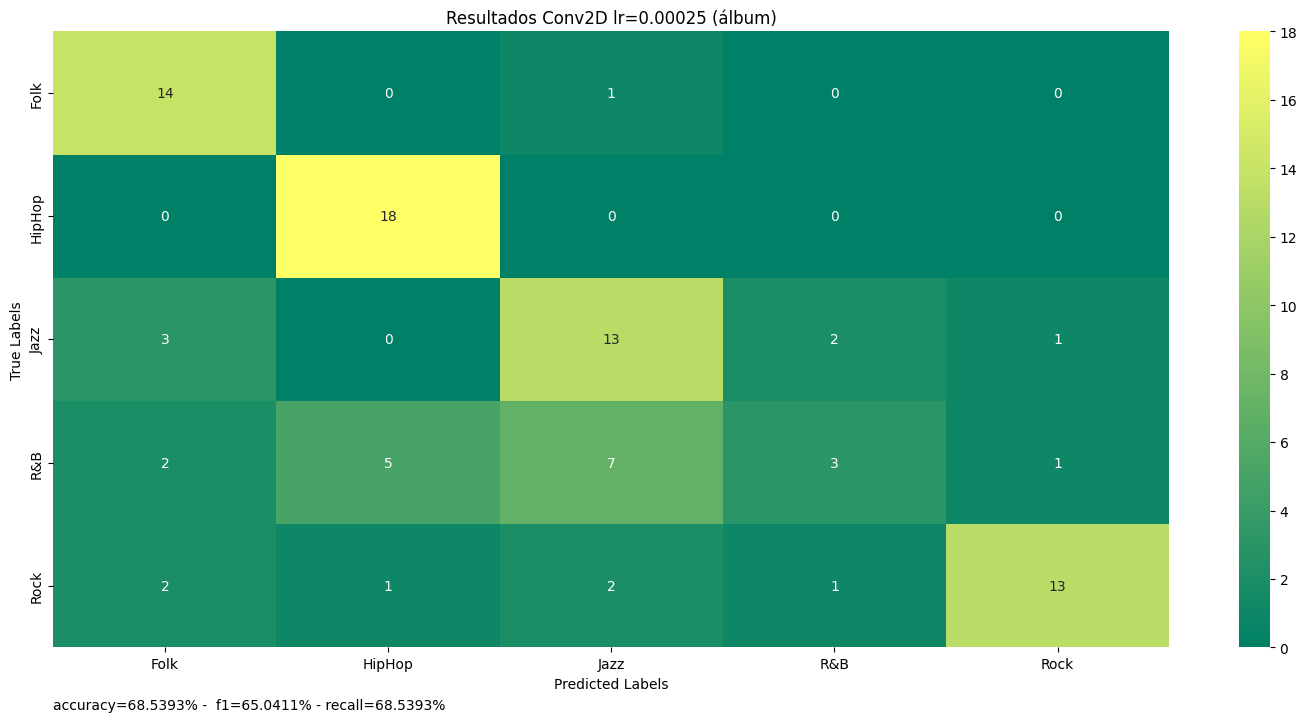

In [4]:
from matplotlib import pyplot as plt
from tensorflow import keras
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import pickle

# model = pickle.load(open('model/output 20240601/XGBClassifier', 'rb'))
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(X, y)

# p1 = clf.predict(X1)

# model = keras.models.load_model('./model/output/keras/Conv2D_lr-0000025/simpleConv2D.keras')
model.load_weights('./model/output/keras/Conv2D_lr-00005/model_CONV2D_3.h5')
p1_keras = model.predict(X1)

p1 = np.zeros((0, 5))
for l in p_aux:
    p1 = np.concatenate([p1, p1_keras[l[0]:l[1], :].sum(axis=0).reshape((1,5))], axis=0)
res = f'''accuracy={round(metrics.accuracy_score(y1_albums.argmax(axis=1), p1.argmax(axis=1))*100, 4)}% -  f1={round(metrics.f1_score(y1_albums.argmax(axis=1), p1.argmax(axis=1), average="weighted")*100, 4)}% - recall={round(metrics.recall_score(y1_albums.argmax(axis=1), p1.argmax(axis=1), average="weighted")*100, 4)}%'''
print(len(p_aux))
print(res)

plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y1_albums.argmax(axis=1), p1.argmax(axis=1)), annot = True, xticklabels = genres, yticklabels = genres, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Resultados Conv2D lr=0.00025 (álbum)')
plt.text(0, 5.5, res)
plt.show()

In [23]:
y1_albums.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4], dtype=int64)

In [24]:
p1.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       0], dtype=int64)

In [26]:
test_albums[test_albums['HipHop']]

,Album,Position,Length,Folk,HipHop,Jazz,R&B,Rock
80,Digable Planets - Blowout Comb,"(57446, 64965)",7519,False,True,False,False,False
116,Nas - Illmatic,"(83597, 88390)",4793,False,True,False,False,False
71,Clipse - Hell Hath No Fury,"(52186, 57882)",5696,False,True,False,False,False
131,"Tyler, the Creator - Call Me If You Get Lost","(95168, 101507)",6339,False,True,False,False,False
115,Mos Def - Black on Both Sides,"(82739, 91326)",8587,False,True,False,False,False
87,Ghostface Killah - Supreme Clientele,"(62214, 69928)",7714,False,True,False,False,False
101,Kanye West - My Beautiful Dark Twisted Fantasy,"(72635, 80878)",8243,False,True,False,False,False
94,JPEGMAFIA & - Scaring the Hoes,"(67771, 76220)",8449,False,True,False,False,False
95,JPEGMAFIA - All My Heroes Are Cornballs,"(68615, 74116)",5501,False,True,False,False,False
121,Public Enemy - It Takes a Nation of Millions t...,"(87346, 94022)",6676,False,True,False,False,False


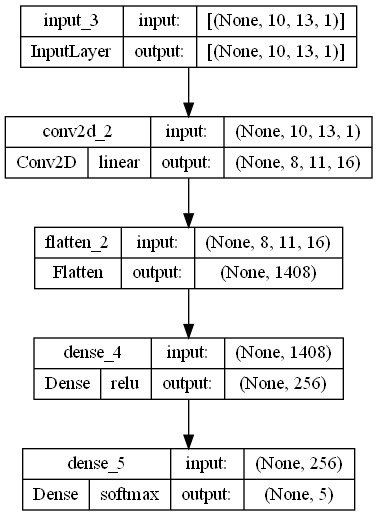

: 

In [7]:
from keras import models
from keras.utils import plot_model
model = models.load_model('./model/output/keras/Conv2D_lr-000025/simpleConv2D.keras')
plot_model(model, './model.png', show_layer_activations=True, show_shapes=True)

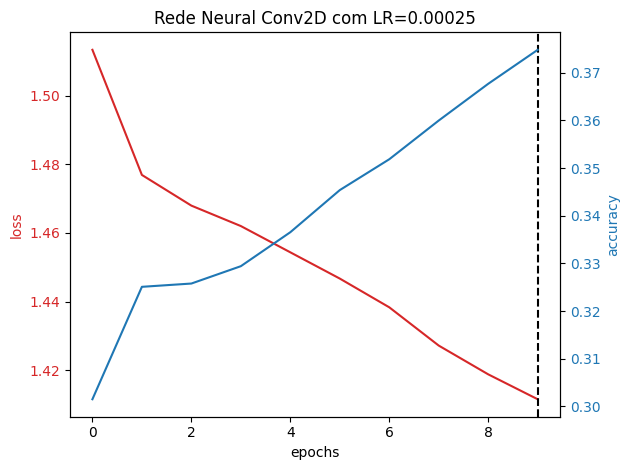

In [42]:
from matplotlib import pyplot as plt
import json

loss = json.load(open('./model/output/keras/LSTM_lr-000025/history'))['loss'] 
accuracy = json.load(open('./model/output/keras/LSTM_lr-000025/history'))['accuracy']


val_loss = json.load(open('./model/output/keras/LSTM_lr-000025/history'))['val_loss'] 
val_accuracy = json.load(open('./model/output/keras/LSTM_lr-000025/history'))['val_accuracy']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(range(len(loss)), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(accuracy)), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Rede Neural Conv2D com LR=0.00025')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.annotate(f"loss={round(loss[-1], 4)}", (42, 1))
ax2.annotate(f"acc={round(accuracy[-1], 2)}", (42, 0.60))

ax1.axvline(val_accuracy.index(max(val_accuracy)), linestyle="--", color='black')
ax2.annotate(f"max val_acc={round(max(val_accuracy), 4)}\nepoch={val_accuracy.index(max(val_accuracy))}", (45, 0.55),
             horizontalalignment='right')
plt.show()

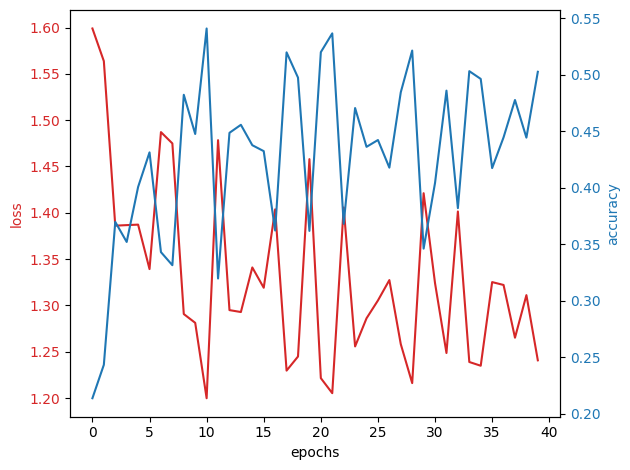

In [17]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(range(40), val_history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(range(40), val_history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [24]:
from sklearn.manifold import TSNE

position = []
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(df[:,:13])
X_2d = np.concatenate([X_2d, df[:, -5:]], axis=1)

c:\Users\luish\miniconda3\envs\sound-s\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\luish\miniconda3\envs\sound-s\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [36]:
folk_coordinates = X_2d[np.where(X_2d[:,2]==1),:2][0]
hiphop_coordinates = X_2d[np.where(X_2d[:,3]==1),:2][0]
rnb_coordinates = X_2d[np.where(X_2d[:,4]==1),:2][0]
jazz_coordinates = X_2d[np.where(X_2d[:,5]==1),:2][0]
rock_coordinates = X_2d[np.where(X_2d[:,6]==1),:2][0]

(69224, 2)

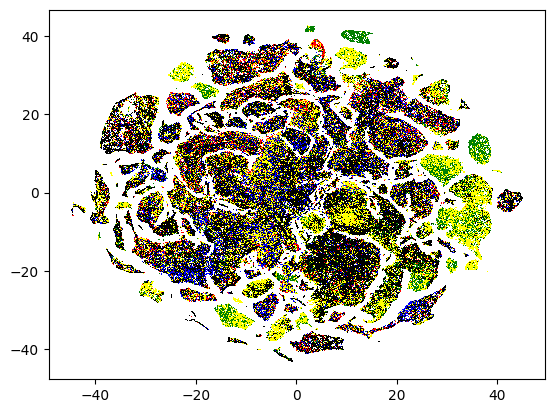

In [50]:
from matplotlib import pyplot as plt

plt.plot(folk_coordinates[:,0], folk_coordinates[:,1], ',',linewidth=None, color='red')
plt.plot(hiphop_coordinates[:,0], hiphop_coordinates[:,1], ',',linewidth=None, color='green')
plt.plot(rnb_coordinates[:,0], rnb_coordinates[:,1], ',',linewidth=None, color='blue')
plt.plot(jazz_coordinates[:,0], jazz_coordinates[:,1], ',',linewidth=None, color='yellow')
plt.plot(rock_coordinates[:,0], rock_coordinates[:,1], ',',linewidth=None, color='black')